### GreenDS

# Fundamentals of Agro-Environmental Data Science

## Example APIs and Web scraping

### Introduction

The purpose of this Jupyter Notebook exercise is to demonstrate the methods available to obtain data from online services. Two examples are explored:
- web data services based on REST APIs
- web scraping from online web pages

Sometime, web pages use APIs to expose information and services, but no documentation is provided. We will learn how to identify the existence of these services, to use them in more efficient data collection.

## 1. Web scraping list of TOP TV SHOWS

This was the example run in class. It is based on the Jupyter Notebook provided 
by Mrityunjay Pathak in [Kaggle](https://www.kaggle.com/discussions/general/527927). 
The goal is to create a list of IMDB Top 250 TV Shows by web scrapping. The code 
is made available [as a Jupyter Notebook](https://github.com/TheMrityunjayPathak/Data-Science-with-Python/blob/main/Web%20Scrapping/Web%20Scrapping%20with%20Python.ipynb) in Github.

First, we need to import the following libraries:

**pandas**
- This library is used for data manipulation and analysis.
- It provides powerful data structures like DataFrames which are great for organizing and analyzing data scraped from websites.
- For example, after scraping data you can use pandas to clean and save the data in various formats like CSV or Excel.

**requests**
- This library allows you to send HTTP requests using Python.
- It's often used to fetch the HTML content of a webpage.
- With requests, you can easily retrieve the page source which can then be parsed to extract the desired information.

**BeautifulSoup**
- This library is used for parsing HTML and XML documents.
- It makes it easy to navigate and search the HTML structure of a webpage.
- After retrieving the HTML content using requests you can use BeautifulSoup to parse and extract specific elements of the webpage. 

In [36]:
# import necessary libraries
import pandas as pd
# requests
import requests
# BeautifulSoup
from bs4 import BeautifulSoup

Now, let's obtain the source html code of the web page with the list we want to obtain.

In [37]:
# URL of IMDb's Top TV page
url = "https://www.imdb.com/chart/toptv/"

# Set headers to mimic a real browser visit
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# Send GET request to the webpage
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Get page content
    page_source = response.text
    # Parse with BeautifulSoup
    soup = BeautifulSoup(page_source, "html.parser")
    # Display or process the parsed page
    print(soup.prettify()[:500])
else:
    print(f"Failed to retrieve page. Status code: {response.status_code}")

<!DOCTYPE html>
<html lang="en-US" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://opengraphprotocol.org/schema/">
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width" name="viewport"/>
  <script>
   if(typeof uet === 'function'){ uet('bb', 'LoadTitle', {wb: 1}); }
  </script>
  <script>
   window.addEventListener('load', (event) => {
        if (typeof window.csa !== 'undefined' && typeof window.csa === 'function') {
            var csaLatencyPlugin = window.csa(


Using BeautifullSoup, we can extract the main title of the base, which is formatted 
in HTML with the tag `<h1>`. We will print the result. This corresponds to this part of the webpage.

Using the Inspector tool in your browser you can confirm that this is a heading **h1**.

<img src="https://raw.githubusercontent.com/TheMrityunjayPathak/Data-Science-with-Python/main/Web%20Scrapping/images/heading.png" width="500px" border="2px solid black">

In [38]:
# Heading of the Webpage
heading = soup.find("h1").text
print(heading)

Top 250 TV Shows


Now, let's obtain the TV Show names.

<img src="https://raw.githubusercontent.com/TheMrityunjayPathak/Data-Science-with-Python/main/Web%20Scrapping/images/tv%20show%20name.png" width="500px" border="2px solid black">

In [39]:
# TV Shows Name
lst1 = []
for i in soup.find_all("h3","ipc-title__text"):
    lst1.append(i.text)

print(lst1)

['IMDb Charts', '1. Breaking Bad: Ruptura Total', '2. Planet Earth II', '3. Planet Earth', '4. Irmãos de Armas', '5. Chernobyl', '6. The Wire', '7. Avatar: O Último Airbender', '8. Blue Planet II', '9. Os Sopranos', '10. Cosmos: A Spacetime Odyssey', '11. Cosmos', '12. Our Planet', '13. A Guerra dos Tronos', '14. Bluey', '15. The World at War', '16. Hagane no renkinjutsushi', '17. Rick e Morty', '18. Life - Vida Selvagem', '19. The Last Dance', '20. No Limiar da Realidade', '21. The Vietnam War', '22. Sherlock', '23. Ataque dos Titãs', '24. Batman: A Série Animada', '25. O Escritório', 'Recently viewed']


In [40]:
# To remove additional <h3> Text from TV Shows Name
lst1 = lst1[1:251]
print(lst1)

['1. Breaking Bad: Ruptura Total', '2. Planet Earth II', '3. Planet Earth', '4. Irmãos de Armas', '5. Chernobyl', '6. The Wire', '7. Avatar: O Último Airbender', '8. Blue Planet II', '9. Os Sopranos', '10. Cosmos: A Spacetime Odyssey', '11. Cosmos', '12. Our Planet', '13. A Guerra dos Tronos', '14. Bluey', '15. The World at War', '16. Hagane no renkinjutsushi', '17. Rick e Morty', '18. Life - Vida Selvagem', '19. The Last Dance', '20. No Limiar da Realidade', '21. The Vietnam War', '22. Sherlock', '23. Ataque dos Titãs', '24. Batman: A Série Animada', '25. O Escritório', 'Recently viewed']


In [41]:
# Initialize an empty list to store names
name_list = []

# Loop through each item in the list
for i in lst1:
    parts = i.split(".")
    if len(parts) > 1:  # Ensure there are at least two parts after splitting
        name_list.append(parts[1].strip())  # Append the second part after stripping extra whitespace
    else:
        print(f"Skipping item '{i}' as it doesn't contain a period.")

print(name_list)

Skipping item 'Recently viewed' as it doesn't contain a period.
['Breaking Bad: Ruptura Total', 'Planet Earth II', 'Planet Earth', 'Irmãos de Armas', 'Chernobyl', 'The Wire', 'Avatar: O Último Airbender', 'Blue Planet II', 'Os Sopranos', 'Cosmos: A Spacetime Odyssey', 'Cosmos', 'Our Planet', 'A Guerra dos Tronos', 'Bluey', 'The World at War', 'Hagane no renkinjutsushi', 'Rick e Morty', 'Life - Vida Selvagem', 'The Last Dance', 'No Limiar da Realidade', 'The Vietnam War', 'Sherlock', 'Ataque dos Titãs', 'Batman: A Série Animada', 'O Escritório']


We can also identify and obtain the rating of the TV shows. It is only necessary 
with the inspector identify which html tag and css class is used in the webpage.

It is `span` and `ipc-rating-star--rating`, that we can use to identify the values
in BeautifulSoup.

<img src="https://raw.githubusercontent.com/TheMrityunjayPathak/Data-Science-with-Python/main/Web%20Scrapping/images/ratings.png" width="500px" border="2px solid black">

In [42]:
# IMDB Rating
rating = []
for i in soup.find_all("span","ipc-rating-star--rating"):
    rating.append(i.text.strip())

print(rating)

['9.5', '9.5', '9.4', '9.4', '9.3', '9.3', '9.3', '9.3', '9.2', '9.2', '9.3', '9.2', '9.2', '9.3', '9.2', '9.1', '9.1', '9.1', '9.1', '9.0', '9.1', '9.1', '9.1', '9.0', '9.0']


We can do the same o get the number of votes.

<img src="https://raw.githubusercontent.com/TheMrityunjayPathak/Data-Science-with-Python/main/Web%20Scrapping/images/votes.png" width="500px" border="2px solid black">

In [43]:
# Aggregated loop for extracting and cleaning votes
votes = []
for i in soup.find_all("span", "ipc-rating-star--voteCount"):
    votes.append(i.text.strip().replace("(", "").replace(")", "").strip())

print(votes)

['2.2M', '162K', '223K', '544K', '905K', '390K', '388K', '48K', '497K', '131K', '45K', '53K', '2.4M', '33K', '31K', '208K', '626K', '43K', '159K', '96K', '29K', '1M', '559K', '122K', '744K']


So, we have created three python lists:
- name of the show
- rating
- number of votes

Let's assemble everything in a Pandas Dataframe

In [44]:
# Collecting all the Data into a DataFrame
tv_shows = pd.DataFrame({"Name":name_list,"Ratings":rating,"Votes":votes})
tv_shows.head(10)

,Name,Ratings,Votes
0,Breaking Bad: Ruptura Total,9.5,2.2M
1,Planet Earth II,9.5,162K
2,Planet Earth,9.4,223K
3,Irmãos de Armas,9.4,544K
4,Chernobyl,9.3,905K
5,The Wire,9.3,390K
6,Avatar: O Último Airbender,9.3,388K
7,Blue Planet II,9.3,48K
8,Os Sopranos,9.2,497K
9,Cosmos: A Spacetime Odyssey,9.2,131K


And we can export the full list to a csv file.

In [45]:
# Saving the DataFrame as CSV File
tv_shows.to_csv("tv_shows.csv",index=False)

## 2. Web scrapping Air Quality data

The QUALAR (https://qualar.apambiente.pt/) is a web platform of APA, the Portuguese Environment Agency, that displays online air quality data sampled by on air monitoring stations in Portugal. Unfortunately, the platform does not expose to the final user, or provides documentation how to use the API service that was implemented for web users downloads. Downloads are generated as XLSX files.

However, it is possible to hack the source code of the webpage to identify that there is an implemented API, and that it can be used to facilitate efficient download of data. This exercise will demonstrate that, with the following steps:
- check how are downloads generated from the website
- identify and collect the parameters that define the data download
- use the API to download data
- as a bonus, visualise a timeseries of a data quality variable.

### Prepare your environment

1. Create two directories inside your projects' directory named `raw-data` and `qualar-data`, with the following command:

In [46]:
!mkdir raw-data qualar-data

mkdir: cannot create directory ‘raw-data’: File exists
mkdir: cannot create directory ‘qualar-data’: File exists


### 1. Data download for human users

Visit the data download page of QUALAR, at https://qualar.apambiente.pt/downloads. It displays a table with a list of Air Monitoring Stations, with the following columns:
- Region (Região)
- Municipality (Concelho)
- Station (Estação)
- Station type (Tipo de Estação), with categories traffic, industrial and background
- Área type (Tipo de Área), with categories urban, suburban and rural
- columns for the following pollutants: O3, NO2, CO, SO2, PM10, PM2.5, C6H6, other

On the top, the page has two fields to define the time range for the data download, and filters for type of station, type of area and year.

To make a download, users can click on arrows that are available for each station and each pollutant, or if they want to download all pollutants for a station, they can click directly on the station name. After clicking, the download file is generated for the requested options as a excel file (xlsx).

*Try to make a download in this way, and check the file downloaded.*

### 2. Verify how are downloads generated by inspecting the webpage source code

It is possible to inspect the source code of the table, and the behavior of the page when a download is solicited. Checking this we can try to identify which methods are used to provide data to users. If we manage to verify that the web page is served by an API, and we can identify which parameters define a request, then it would be possible to generate a script to speed up downloads.

**1. Activate the Inspect Tool of the source code of the webpage.**

*Open in your web browser, navigate to https://qualar.apambiente.pt/downloads. Afterwards, in the menu of your browser, find the option **Web Developer Tools** or **Developer Tools** (in Firefox or Chrome, you will find it in **More tools**). This will open a new panel in the browser.*

**2. Check the method to generate downloads**

As mentioned before, clicking on the name of a station will generate a download with all data for that station. This means that through the HTTP protocol, a request is made through the network. Checking which request was made (which URL request was send) is a good way of verifying what was the information send to the web server.

*On the Developer Panel, click on the tab **Network**. After that, click on the name of a station to make a download request. This will generate a new row on the panel, with the information about a **GET** request.*

One of the parameters in that row is the name or file field, which shows the URL sent to the server, e.g.:

```https://qualar.apambiente.pt/api/download.php?poluente_id=0&estacao_id=1021&data_inicio=2023-01-01&data_fim=2023-12-31&influencias=&ambientes=```

We can identify the following sections in the URL:

- Host URL: ```https://qualar.apambiente.pt/api/download.php```

- Parameters:```poluente_id=0&estacao_id=1021&data_inicio=2023-01-01&data_fim=2023-12-31&influencias=&ambientes=```

The meaning of the parameters is more or less obvious:

- `poluente_id` - the ID of the pollutant. The value zero should mean all pollutants

- `estacao_ID` - the ID of the station

- `data_inicio` - starting date

- `data_fim` - ending date

- `influencias` - station type (in this URL its empty)

- `ambientes` - area type (it is also empty)

**3. Verify that the method for download works**

We have just identified an API service for downloading data. We can check if it works, testing with different parameters and see if results correspond to what is expected:

*To download data only for **year 2020**, try the following modified URL:*

```https://qualar.apambiente.pt/api/download.php?poluente_id=0&estacao_id=1021&data_inicio=2020-01-01&data_fim=2020-12-31&influencias=&ambientes=```

The challenge now is to discover the values of the IDs of the air monitoring stations (the parameter `estacao_ID`). If we find these, we can make a script to make automatic requests to download the data files. Notice that the ID with value 1021, in the URL above, corresponds to station with the name **Custóias-Matosinhos**.

### 3. Search all webpage data to find IDs of the stations

This is an advanced task, that requires some persistence. 

From the URL of above, we see that the web platform is using the API do manage 
the download of excel files. This means that the parameters necessary to download 
the files, like the ID of the stations need to have been made available to the 
client, in this case, our browser. We only need to dig a bit more to find in which
form it was provided.

**1. Find the station ID data**

With the browser **Developer Tools** open in the **Network** tab, 
navigate to the address [https://qualar.apambiente.pt](https://qualar.apambiente.pt), 
and then select Downloads on the left menu. The Network panel will show 
many files that are received by the browser. 

Using the search too in the Developer Tools (the magnify glass), search for the 
name of one station, for example "Ermesinde".

The result will include at least one file named **app.php**. Select the file, and
in the list of files, double click it to open in the browser. You will notice 
that this is a JSON file containing the list of stations, including their IDs. 
With the file, you can implement a routine to download data files using the API.

However, for the purpose of the current exercise on using BeautifulSoup, we will use
a previous static version of the site's HTML.

### 4. Get air pollution station IDs**

Download the static HTML to your local disk.

In [47]:
# Set the GitHub raw file URL of the HTML
file_url = "https://raw.githubusercontent.com/isa-ulisboa/greends-fads-jupyter/refs/heads/main/example02-apis/raw-data/qualar_table.html"

# Set the file path for saving locally
save_path = "./raw-data/qualar_table.html"  # Replace with desired local filename

# Download the file
response = requests.get(file_url)
if response.status_code == 200:
    with open(save_path, "wb") as file:
        file.write(response.content)
    print(f"File downloaded and saved as {save_path}")
else:
    print("Failed to download file:", response.status_code)

File downloaded and saved as ./raw-data/qualar_table.html


Extract the station ID from the html text using BeautifulSoup. We will store the list of station IDs in a list to use latter.

In [48]:
# open the html file
with open("./raw-data/qualar_table.html") as html_table:
    soup = BeautifulSoup(html_table, 'html.parser')

# create a list to store ids
station_ids = []


# get ids from html
for row in soup.find_all('label'):
    row_text = row['onclick']
    ids = row_text[row_text.find( '(' )+1:row_text.find( ')' )]
    station_ids.append(ids)
    
print(station_ids)

['1041', '1042', '1054', '1053', '1046', '1100', '1024', '1031', '1021', '1025', '1030', '1034', '1055', '1043', '1044', '1028', '1050', '1052', '1023', '1047', '1048', '1051', '2017', '2006', '2016', '2004', '2020', '2019', '2022', '2021', '2018', '3083', '3082', '3084', '3055', '3095', '3103', '3104', '3096', '3070', '3071', '3072', '3075', '3087', '3100', '3085', '3102', '3097', '3091', '3099', '3063', '3092', '3093', '3094', '3089', '3101', '4006', '4002', '4003', '4004', '4001', '5008', '5012', '5007', '5011', '6004', '6005', '6008', '7001']


### 5. Download files using the API

We can now make requests to the API to download xlsx files. First, let's import the python modules.

In [49]:
# import necessary libraries
import requests
import datetime
import pandas as pd
from time import sleep
import urllib

After that, we will request to the REST API the excel files for each stattion, identified by its ID, and store them localy. 

In [50]:
# Define base URL of the service
base_url = 'https://qualar.apambiente.pt/api/download.php'

# Define params for the API request
params = {"poluente_id":"0", "influencias":"1,2,3", "ambientes":"1,2,4"}

# Define begining of the data period. You can change this for another year
params["data_inicio"] = "2021-01-01"

# Define end of the data period. You can change this for another year
params["data_fim"] = "2021-12-31"

# As this is not in production, we will replace the full list of ids by a smaller list of ids, to save time. 
# If you want all data, comment the next line
station_ids = ['3095', '3103', '3104', '3096', '3070']

# This iteration will go through the list of IDs, request the excel file based on the URL and save it locally.
for id_value in station_ids:
    # define name of file to be saved
    filename = './qualar-data/station_'+ id_value + '.xlsx'
    # add station_id to the parameters of the URL
    params["estacao_id"] = id_value
    try:
        r = requests.get(base_url, params)
    except requests.exceptions.RequestException as e: 
        raise SystemExit(e)
    print(r.url)
    with open(filename, 'wb') as f:
        f.write(r.content)

https://qualar.apambiente.pt/api/download.php?poluente_id=0&influencias=1%2C2%2C3&ambientes=1%2C2%2C4&data_inicio=2021-01-01&data_fim=2021-12-31&estacao_id=3095
https://qualar.apambiente.pt/api/download.php?poluente_id=0&influencias=1%2C2%2C3&ambientes=1%2C2%2C4&data_inicio=2021-01-01&data_fim=2021-12-31&estacao_id=3103
https://qualar.apambiente.pt/api/download.php?poluente_id=0&influencias=1%2C2%2C3&ambientes=1%2C2%2C4&data_inicio=2021-01-01&data_fim=2021-12-31&estacao_id=3104
https://qualar.apambiente.pt/api/download.php?poluente_id=0&influencias=1%2C2%2C3&ambientes=1%2C2%2C4&data_inicio=2021-01-01&data_fim=2021-12-31&estacao_id=3096
https://qualar.apambiente.pt/api/download.php?poluente_id=0&influencias=1%2C2%2C3&ambientes=1%2C2%2C4&data_inicio=2021-01-01&data_fim=2021-12-31&estacao_id=3070


### 6. Preview dowloaded data

We can import xlsx data to Pandas, and make a plot.

In [51]:
import pandas as pd
import os
import matplotlib.pyplot as plt

Let's print the list of available excel files:

In [52]:
# list xlsx files in the data directory

files = os.listdir('./qualar-data')
print(files)

['station_3096.xlsx', 'station_3095.xlsx', 'station_3103.xlsx', 'station_3070.xlsx', 'station_3104.xlsx']


The following imports the files to a Pandas dataframe, and creates a plot with all variables for each station.

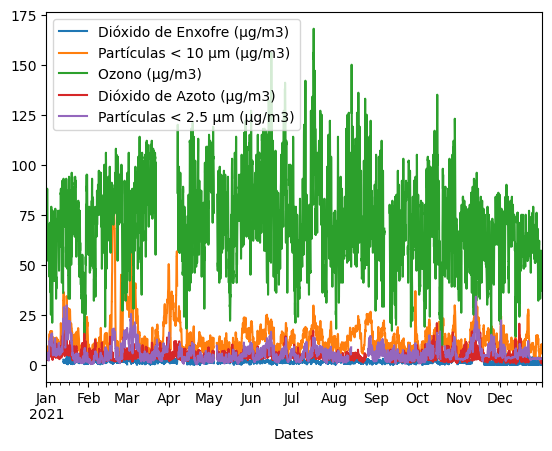

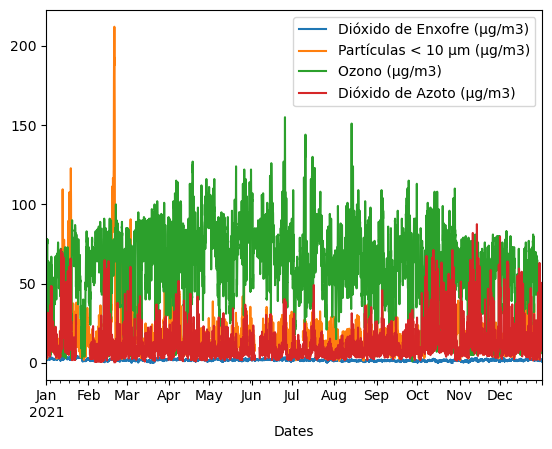

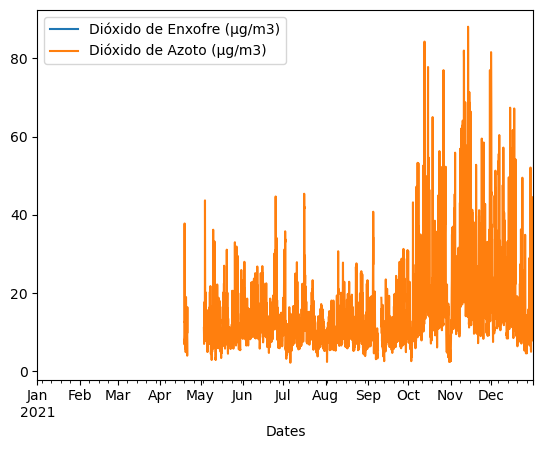

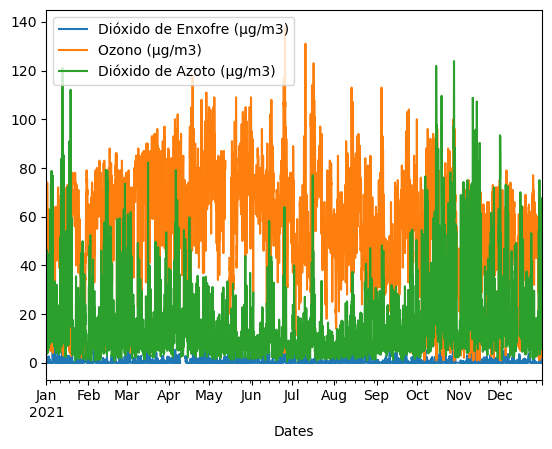

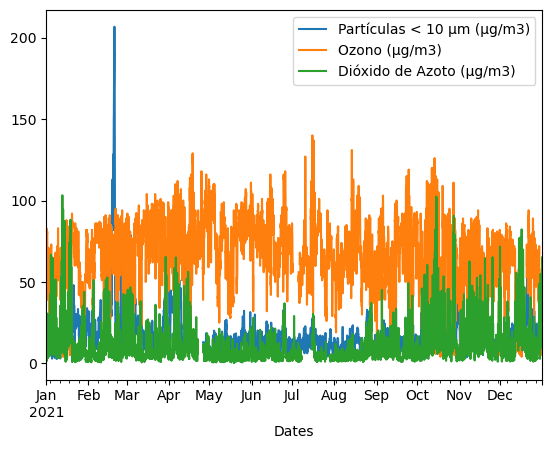

In [53]:
# For each file, import to a pandas dataframe and make a plot
for file in files:
    # define file name
    xls = './qualar-data/'+file
    # read to a pandas dataframe
    df = pd.read_excel(xls)
    
    # create a list with column names of the dataframe 
    col_names = list(df.columns)
    
    # Convert the column with dates to a datetime format
    df['Dates'] = pd.to_datetime(df[col_names[0]])

    # plot all variables, setting dates as the index
    df.set_index('Dates').plot()